## Experiment Playbook

<p>
    Mal Minhas, 23.10.22
</p>

This notebook attempts to explain marketplace experimentation from first principles.  We walk through the steps to take in order to determine whether a particular set of conversion results in a given population is **statistically significant (statsig)**, or not.  In order to do this we create a collection of 20000 users, shuffle them then assign each user to one of two equal cohorts, A and B.  These are intended to simulute our control and test cohort respectively.  Imagine we apply a treatment to B and hypothesise that it will result when the treatment is applied to cohort B using an A/B testing framework.  How can we determine if the results we achieve as a result of this application is indeed statisticallly significant?  We can run 1000 simulated trials where we distribute an equal number of conversions across the two cohorts at random.  The resulting normal distribution enables us to assess how likely it is that any one particular result obtains would satisfy the **null hypothesis** which is that there is no  statistically significant difference between cohorts A and B.  This would be the case in the absence of any treatment if we conducted a series of so-called A/A tests with the same two cohorts.  If we can show a result as extreme as ours has a 5% or less likelihood of naturally occurring, we can assume that the null hypothesis is rejected.  In this event we can reasonably conclude that the treatment has been statistically significant.  In technical terms, our **p-value** or $\alpha$ is the corresponding likelihood of the event occurring naturally.  An $\alpha$ of 0.05 is indicative of a rejection of the null hypothesis.  Our **statsig** value is just $1-\alpha$ so an alternative framing is that if we achieve a statsig of 95%+ we reject the null hypothesis:
<p>
$$\alpha <= 0.05$$
$$statsig = 1-\alpha$$
</p>

Once we have created our two cohorts, we can run 1000 simulations where we randomly distribute conversions across the two cohorts.  This allows us to build a graphical **normal distribution** that we can inspect to calculate the likelihood of a result at least as extreme as the one we suggest.  We can use this distribution to develop an intuitive understanding of the underlying statistics to more readily see how a particular result causes us to reject the null hypothesis.

### Creating our users

Let's start by creating our 20000 users which we will model as a list of 20k dictionaries of user data. We will split them at random into two equal **A** (control) and **B** (test) cohorts.  The following code creates our user dictionaries and employs `random.shuffle` to mix them around.  A number of asssertion checkss are included to make sure our cohorts are  equal size and add up to 20k. 

In [1]:
import uuid
import random

def createUser(i):
    ''' Create a user with a unique uuid. '''
    user = {}
    user['id'] = uuid.uuid1().hex
    user['cvr'] = 0 
    if i%2 == 0:
        user['cohort'] = 'A'
    else:
        user['cohort'] ='B'
    return user

def createTwoEqualCohorts(N):
    everyone = [createUser(i) for i in range(N)]
    random.shuffle(everyone)
    getCohort = lambda letter: [u for u in everyone if u.get('cohort') == letter]
    cohortA = getCohort('A')
    cohortB = getCohort('B')
    assert(len(cohortA) == len(cohortB))
    assert(len(cohortA) == N/2)
    return everyone, cohortA, cohortB

allUsers, cohortA, cohortB = createTwoEqualCohorts(20000)

Let's print a few of the resulting users to see what they look like:

In [2]:
for u in allUsers[25:28]:
    print(u)

{'id': '8b49094452e711edbc47acde48001122', 'cvr': 0, 'cohort': 'A'}
{'id': '8b4dc5ce52e711edbc47acde48001122', 'cvr': 0, 'cohort': 'B'}
{'id': '8b48110652e711edbc47acde48001122', 'cvr': 0, 'cohort': 'B'}


### Simulating an extreme result

Imagine we have 375 conversions spread across cohortA and 425 conversions spread across cohortB.  Intuition suggests this is a relatively extreme result in terms of a random distribution of 800 conversions acrosss the two equal cohorts.  How can we model it?  Let's start by writing some simple functions that allow us to randomly distribute N conversions across a cohort.  We can test we are able to populate cohortA with those functions using `assert` as follows:

In [3]:
def generateNRandomIndexes(N, end, start=0):
    ''' Generate N random indices in range from start to end '''
    idx = []
    while len(idx) < N:
        x = (int(random.random() * (end-start))) + start
        assert(x >=start and x <= end)
        idx.append(x)
    assert(len(idx) == N)
    return sorted(idx)

def populateNConversionsAtRandom(N, cohort):
    #print(f"Populating {N} conversions in cohort of len {len(cohort)}")
    converted_users = []
    idx = generateNRandomIndexes(N, len(cohort))
    for i, x in enumerate(idx):
        user = cohort[i]
        user['cvr'] = 1
        converted_users.append({'cvr':user.get('cvr'), 'cohort':user.get('cohort')})
    return converted_users

def resetConversions(cohort):
    for user in cohort:
        user['cvr'] = 0
    return cohort

def countConversions(cohort):
    countA = 0
    countB = 0
    for user in cohort:
        if user.get('cvr') == 1:
            if user.get('cohort') == 'A':
                countA += 1
            elif user.get('cohort') == 'B':
                countB += 1
    return countA, countB

def getConversions(cohort):
    converted_users = []
    for user in cohort:
        if user.get('cvr') == 1:
            converted_users.append(user)
    return converted_users

# populate cohortA with 375 conversions, check we count 375 conversions, reset and count we have 0 again.
resetConversions(cohortA)
assert(countConversions(cohortA) == (0,0))
populateNConversionsAtRandom(375, cohortA)
assert(countConversions(cohortA) == (375, 0))
resetConversions(cohortA)
assert(countConversions(cohortA) == (0,0))

We can extend the test to ensure we are able to populate a fixed number of conversions per cohort to generate the extreme result:

In [4]:
resetConversions(allUsers)
populateNConversionsAtRandom(375, cohortA)
populateNConversionsAtRandom(425, cohortB)
assert(countConversions(allUsers) == (375,425))
print(f"We found {countConversions(allUsers)} conversions across (cohortA,cohortB)")
resetConversions(allUsers)
assert(countConversions(allUsers) == (0,0))

We found (375, 425) conversions across (cohortA,cohortB)


### Creating an A/A testing distribution

Now let's pack what we've done so far up into a method `generateRandomConversionDistibution` that allows us to randomly distribute N conversions across a cohort.  We will use this to distribute 800 conversions across our 20k users in `allUsers` to simulate A/A testing.  This is an equivalent conversion rate of 4% which is really good by ecommerce marketplace standards.  Note the method we write will by default shuffle and reset any existing conversions before generating a random distribution.  This is important to ensure it is idempotent and there are no side effects between each execution.  In the next code block we execute `generateRandomConversionDistibution` a couple of times to see what results we get.

In [5]:
def generateRandomConversionDistibution(N, cohort, shuffle=True):
    random.shuffle(cohort)
    resetConversions(cohort)
    assert(countConversions(cohort) == (0,0))
    converted_users = populateNConversionsAtRandom(N, cohort)
    #print(converted_users)
    countA, countB = countConversions(cohort)
    assert(countA + countB == N)
    return countA, countB
    
print(generateRandomConversionDistibution(800, allUsers))
print(generateRandomConversionDistibution(800, allUsers))

(399, 401)
(345, 455)


Now let's run this 1000 times with the 800 conversions spread across cohorts A and B to simulate a 4% conversion rate to build our A/A test distribution.  We will time this operation:

In [6]:
%%time

distribution = []
for i in range(1000):
    countA, countB = generateRandomConversionDistibution(800, allUsers)
    distribution.append({'cohortA': countA, 'cohortB': countB})

CPU times: user 17.9 s, sys: 58.3 ms, total: 18 s
Wall time: 18.1 s


### Assessing how extreme our particular original result was

We want to understand how likely it was that we would have got a split of 425 and 375 coversions across cohorts A and B respectively at random from A/A testin.   We can use the results in our `distribution` to help us out.  Let's first create a `pandas` dataframe `df` which has two columns countA and countB holding our counts:

In [7]:
import pandas as pd

df = pd.DataFrame(distribution)
print(df.shape)
df.head(3)

(1000, 2)


,cohortA,cohortB
0,404,396
1,394,406
2,396,404


Let's have a look at some of the stats values for this distribution:

In [8]:
df.describe()

,cohortA,cohortB
count,1000.000000,1000.000000
mean,400.514000,399.486000
std,14.512699,14.512699
min,340.000000,354.000000
25%,391.000000,390.000000
50%,400.000000,400.000000
75%,410.000000,409.000000
max,446.000000,460.000000


Our standard deviation or $\sigma$ is 13.75 in both cases.  This means our variance which is $\sigma^2$ is 189.06.  This is important in respect of understanding effect size or $\delta$ relative to sample size $n$:
<p>
$$n = 16 \sigma^2 / \delta^2$$
</p>

Let's plot a histogram of the distribution of cohortA and cohortB and include lines at the cutoff values of 375 for cohortA and 425 for cohortB:

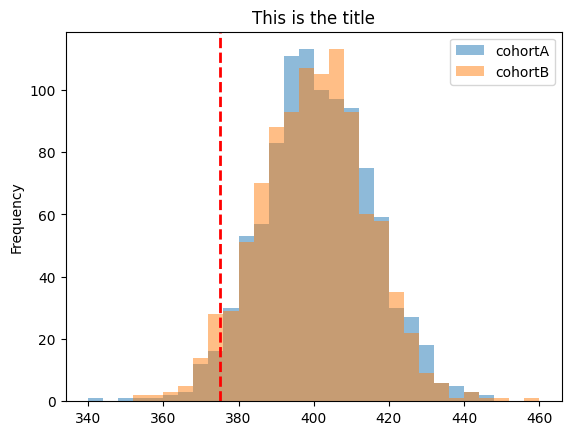

In [9]:
def plotDistribution(N, lines=[]):
    ax = df.plot.hist(bins=N, alpha=0.5)
    ax.set_title(f"This is the title")
    for line in lines:
        ax.axvline(line, color='red', linestyle='dashed', linewidth=2)
    
plotDistribution(30, [375])

We observe a close overlap between the distribution of cohortA and cohortB as we would expect from A/A testing.  We can run a **t-test** across the two cohorts to measure the p-value of their difference:

In [10]:
import scipy.stats as stats
# Perform the two sample t-test with equal variances
stats.ttest_ind(a=df.cohortA, b=df.cohortB, equal_var=True)

Ttest_indResult(statistic=1.5839079516348582, pvalue=0.11337292567948021)

We can now calculate our p-value $\alpha$ for our extreme value by counting up how many results in the normal distribution lie outside the extrema values we measured.  First of all we calculate our cohortA value:

In [11]:
a = len(df.cohortA[df.cohortA <= 375]) / len(df.cohortA)
a

0.037

We are not running a two-sided test here as we constrained the overall number of Our $\sigma$ is therefore the one for cohort A.  If this value is less than 0.05 then the null hypothesis is rejected.  If it is 0.05 or above, then the null hypothesis is proven.  In actuality, our $\sigma$ alpha would be sampled multiple times during a test and we would be tracking our significance over time accordingly.

### Modelling a difference in results between cohortss

TBD.  We want to generate and plot an example A/B testing scenario where A and B are quite different.